Реализация логистической регрессии в tensorflow.

Реализовать модель логистической регрессии. На базе шаблона [004-classification.ipynb](https://github.com/a4tunado/lectures/blob/master/004/004-classification.ipynb) необходимо реализовать операцию [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) в модели логистической регрессии.

### Решение

Реализуем логистическую регрессию с использованием tensorflow.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow.compat.v1 as tf
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class TensorFlowLogisticRegression(BaseEstimator, ClassifierMixin):
    
    supported_optimizers = ["sgd", "nesterov", "rmsprop", "adam"]
    
    """
    Параметры:
    ----------
    epoch: количество эпох обучения методом mini-batch gradient descent
    batch_size: размер батча данных
    optimizer: используемый алгоритм, возможные значения "sgd","nesterov","rmsprop", "adam"
    learning_rate: скорость обучения
    momentum: параметр momentum в оптимизаторе Нестерова
    verbose: вывод отладочной информации при работе алгоритма
    """
    def __init__(self,
                 epoch=100,
                 batch_size=32,
                 optimizer="nesterov",
                 learning_rate=0.01,
                 momentum=0.9,
                 shuffle=True,
                 verbose=False):
        
        self.epoch = epoch
        self.batch_size = batch_size
        if optimizer not in self.supported_optimizers:
            raise ValueError("Invalid solver '%s' specified." % optimizer)
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.shuffle = shuffle
        self.verbose = verbose

    def _print(self, msg, *msg_args):
        if not self.verbose:
            return
        if self.verbose < 50:
            writer = sys.stderr.write
        else:
            writer = sys.stdout.write
        writer(msg.format(*msg_args) + "\n")

    def fit(self, X_val, y_val):
        assert len(X_val.shape) == 2 and len(y_val.shape) == 1
        assert X_val.shape[0] == y_val.shape[0]

        # M - кол-во образцов, N - кол-во признаков
        M, N = X_val.shape

        self.class_values, y_idx = np.unique(y_val, return_inverse=True)
        
        # K - количество классов
        K = len(self.class_values)
        
        if self.optimizer == "sgd":
            solver = tf.train.GradientDescentOptimizer(self.learning_rate)
        elif self.optimizer == "nesterov":
            solver = tf.train.MomentumOptimizer(self.learning_rate, momentum=self.momentum)
        elif self.optimizer == "rmsprop":
            solver = tf.train.RMSPropOptimizer(self.learning_rate)
        elif self.optimizer == "adam":
            solver = tf.train.AdamOptimizer(self.learning_rate)

        learning_curve, learning_accuracy = [], []

        with tf.Session() as session:

            X = tf.placeholder(dtype=tf.float32, shape=(None, N), name="X")
            y = tf.placeholder(dtype=tf.int64, shape=(None), name="y")

            # подготавливаем (n,k) матрицу коэффициентов, каждый столбец представляет коэффициенты k-го класса
            # инициализируем веса с применением glorot инициализации
            W = tf.Variable(tf.truncated_normal(shape=(N, K), stddev=np.sqrt(2 / (N + K))), dtype=tf.float32)

            # коэффициенты смещения (k,)
            b = tf.Variable(tf.zeros(shape=(K,), dtype=tf.float32))

            # логиты логистической регрессии
            logits = tf.nn.sigmoid(tf.add(tf.matmul(X, W), b))

            # функция издержек, которую минимизируем
            cost = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))

            # оптимизатор
            optimizer = solver.minimize(cost)

            # соберем отдельно также точность модели на обучаемых данных
            correct_prediction = tf.equal(tf.argmax(logits, 1), y) 
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

            self._print("Старт обучения, solver '{}'\n", solver.get_name())

            # инициализация
            session.run(tf.global_variables_initializer())

            # массив индексов для перемешивания
            indices = np.arange(M)

            # размер батча
            batch_size = min(M, self.batch_size)

            # цикл по эпохам
            for epoch in range(self.epoch):

                # перемешиваем индексы если нужно
                if self.shuffle:
                    np.random.shuffle(indices)
                    
                # внутри каждой эпохи данные разбиваются на батчи
                for batch in range(M // batch_size):

                    # выбираем индексы очередного батча
                    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]

                    # сам батч
                    X_batch = X_val[batch_indices]
                    y_batch = y_idx[batch_indices]

                    # выполняем шаг обучения: вычисляем ошибку и обновляем веса
                    loss, _ = session.run(
                        [cost, optimizer],  # указываем, какие операции необходимо выполнить
                        feed_dict={
                            # передаем входные данные для вычисления
                            X: X_batch,
                            y: y_batch
                        })

                    # сохраняем занчения ошибки для построения кривой обучения
                    learning_curve.append(loss)

                    # точность считаем на всех обучаемых данных
                    acc = session.run(accuracy, {X:X_val, y:y_idx})
                    learning_accuracy.append(acc)

                    # выводим текущее значение ошибки для каждого 10го шага
                    if (len(learning_curve) - 1)  % 10 == 0:
                        self._print("[{:0>3}] loss={}, accuracy={}", len(learning_curve) - 1, loss, acc)

            self.weight = W.eval()
            self.bias = b.eval()
        
        self.learning_losses = learning_curve
        self.learning_accuracy = learning_accuracy
        self._print("Конец обучения.\nweights={},\nbias={}\n", str(self.weight), str(self.bias))

    def predict(self, X_val):
        assert(hasattr(self, "class_values"))
        assert len(X_val.shape) == 2 and X_val.shape[1] == self.weight.shape[0]
        
        N, K = self.weight.shape

        with tf.Session() as session:
            X = tf.placeholder(dtype=tf.float32, shape=(None, N), name="X")

            W = tf.constant(self.weight)
            b = tf.constant(self.bias)
            classes = tf.constant(self.class_values.reshape(-1,1))

            logits = tf.nn.sigmoid(tf.add(tf.matmul(X, W), b))
            predict = tf.reshape(tf.gather_nd(classes, tf.reshape(tf.argmax(logits, 1), (-1, 1))), (-1,))

            val = session.run(predict, feed_dict={X : X_val})
            return val

In [4]:
data = load_iris()
X, y = data.data, data.target

In [5]:
X.shape

(150, 4)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [7]:
def visualize_learning_process(m):
    fig = plt.figure(figsize=(20,10))

    fig.add_subplot(121)
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.title("Learning losses")
    plt.plot(m.learning_losses)

    fig.add_subplot(122)
    plt.xlabel("step")
    plt.ylabel("accuracy")
    plt.title("Learning accuracy")
    plt.plot(m.learning_accuracy)
    
    plt.show()

Подберем гиперпараметры модели

In [8]:
%%time
params=dict(
    optimizer=TensorFlowLogisticRegression.supported_optimizers,
    epoch=[10,100],
    batch_size=[16, 32, 64],
    )
gs = GridSearchCV(
    TensorFlowLogisticRegression(),
    params,
    scoring="accuracy",
    cv=4,
    n_jobs=-1)
gs.fit(X_train, y_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


C:\Users\gvs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 33.9 s


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=TensorFlowLogisticRegression(batch_size=32, epoch=100,
                                                    learning_rate=0.01,
                                                    momentum=0.9,
                                                    optimizer='nesterov',
                                                    shuffle=True,
                                                    verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'batch_size': [16, 32, 64], 'epoch': [10, 100],
                         'optimizer': ['sgd', 'nesterov', 'rmsprop', 'adam']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

Построим кривую обучения и изменение точности в процессе обучения

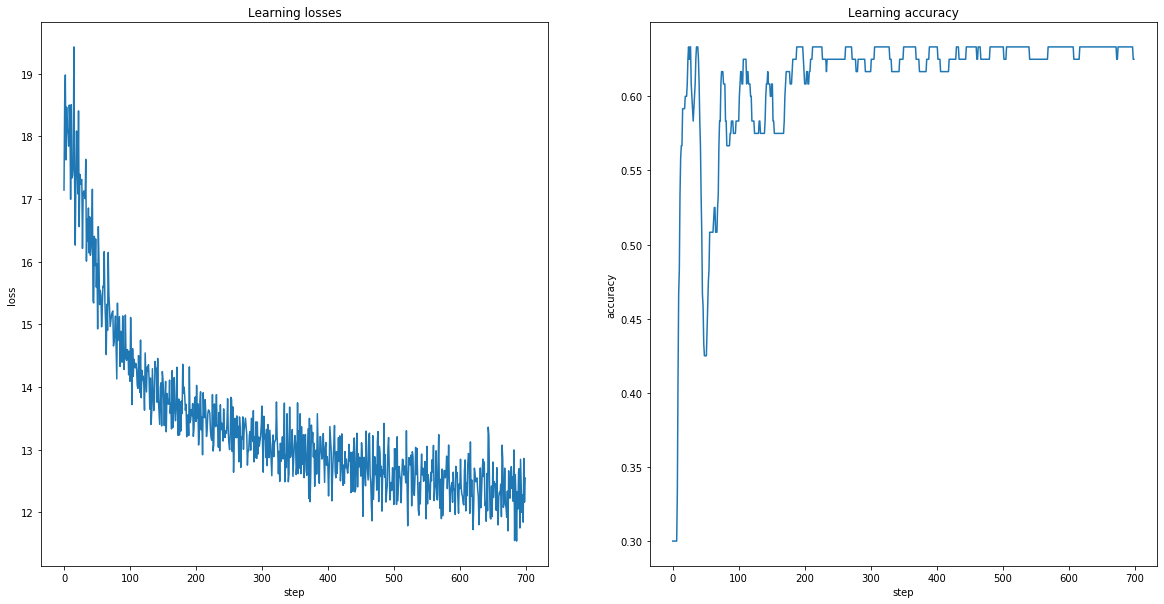

In [9]:
visualize_learning_process(gs.best_estimator_)

Параметры подобранной модели

In [11]:
print(gs.best_params_)

{'batch_size': 16, 'epoch': 100, 'optimizer': 'adam'}


Далее сравним полученную модель и реализацию логистической регресси из пакета sklearn

In [12]:
models = [
    TensorFlowLogisticRegression(**gs.best_params_),
    LogisticRegression(multi_class="multinomial", solver="lbfgs")
]

In [13]:
results = []

for m in models:
    m.fit(X_train, y_train)

    y_pred = m.predict(X_val)

    score_train = m.score(X_train, y_train)
    score_test = m.score(X_val, y_val)
    cm = confusion_matrix(y_val, y_pred)

    results.append((m.__class__.__name__, score_train, score_test, cm))

In [14]:
for name, score_train, score_test, cm in results:
  print("------------------")
  print("Algorithm name:", name)
  print("Accuracy train:", score_train)
  print("Accuracy test:", score_test)
  print("Confusion matrix:\n", cm)

------------------
Algorithm name: TensorFlowLogisticRegression
Accuracy train: 0.6916666666666667
Accuracy test: 0.7666666666666667
Confusion matrix:
 [[ 8  0  0]
 [ 0 14  0]
 [ 0  7  1]]
------------------
Algorithm name: LogisticRegression
Accuracy train: 0.9916666666666667
Accuracy test: 0.9333333333333333
Confusion matrix:
 [[ 8  0  0]
 [ 0 12  2]
 [ 0  0  8]]
